In [ ]:
import numpy as np
import networkx as nx
from dwdynamics import helpers ,instance
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.stats import linregress
import dwave_networkx as dnx
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import dimod

In [2]:
# matplotlib style settings for publication
import matplotlib.font_manager as fm
fm.fontManager.addfont("../times.ttf") 
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['Times New Roman'],
})

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams.update({'font.size': 12})

# Performance comparison Velox vs D-Wave

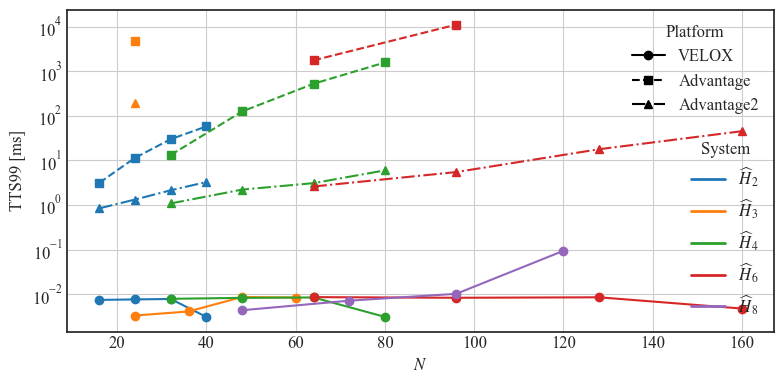

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [i for i in range(1,10)]
systems = [2,3,4,6,8]
ALL_dfs = []

native_systems = [1,2,4,5,6,7]

for idx, system in enumerate(systems):
    df1_filtered = helpers.get_velox_success_rates(system)
    df2_filtered = helpers.get_dwave_success_rates(system=system,ta=200,topology='6.4',file_limit=20)
    df3_filtered = helpers.get_dwave_success_rates(system=system,ta=200,topology='1.4',file_limit=20)

    df1_filtered['source'] = 'VELOX'
    df2_filtered['source'] = 'Advantage'
    df3_filtered['source'] = 'Advantage2'

    combined = pd.concat([df1_filtered,df2_filtered,df3_filtered]).reset_index()
    combined =combined[combined.timepoints.isin([2,3,4,5])]


    combined['system'] = system
    combined['x_label'] = combined['precision'].astype(str) + '\n' + combined['timepoints'].astype(str)
    
    combined['tts99'] = combined.apply(lambda row: helpers.return_tts(row['success_prob'],row.runtime),axis=1)
    df = combined.copy()
    
    velox = df[df['source'] == 'VELOX'].dropna(subset=['num_var', 'tts99'])
    advantage1 = df[df['source'] == 'Advantage'].dropna(subset=['num_var', 'tts99'])
    advantage2 = df[df['source'] == 'Advantage2'].dropna(subset=['num_var', 'tts99'])
    combined = combined[['system','source','precision','num_var','timepoints','runtime','success_prob','tts99']]
    color = colors[idx % len(colors)]
    
    ax.plot(velox['num_var'], velox['tts99'],
            marker='o', linestyle='-', color=color, label=f'system {system}')
    
    ax.plot(advantage1['num_var'], advantage1['tts99'],
            marker='s', linestyle='--', color=color)
    
    ax.plot(advantage2['num_var'], advantage2['tts99'],
            marker='^', linestyle='dashdot', color=color)
    
    ALL_dfs.append(combined)
all_system_dfs = pd.concat(ALL_dfs,axis=0)
native_system_df = all_system_dfs[all_system_dfs.system.isin(native_systems)].groupby(['source','precision','num_var','timepoints']).mean().reset_index().drop(labels=['system'],axis=1)
sources = ['Advantage', 'Advantage2']



# 1st legend : solver
style_legend = [
    Line2D([0], [0], color='black', linestyle='-', marker='o', label='VELOX'),
    Line2D([0], [0], color='black', linestyle='--', marker='s', label='Advantage'),
    Line2D([0], [0], color='black', linestyle='dashdot', marker='^', label='Advantage2')
]

legend1 = ax.legend(handles=style_legend, title='Platform', loc='upper right')

# 2nd legend : systems
color_legend = [
    Line2D([0], [0], color=colors[idx % len(colors)], lw=2, label=fr'$\widehat H_{s}$') for idx, s in enumerate(systems)
]

legend2 = ax.legend(handles=color_legend, title='System', loc='lower right')
ax.add_artist(legend1) 

ax.set_xlabel(r'$N$')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
ax.grid(True)
plt.tight_layout()
plt.savefig(f'../plots/tta_overview.pdf' ,bbox_inches='tight')
ylims = ax.get_ylim()
plt.show()

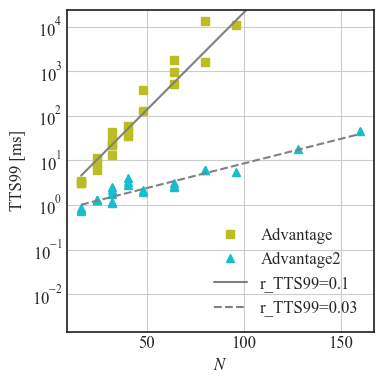

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [i for i in range(1,10)]
systems = [1,2,4,5,6,7]
ALL_dfs = []

for idx, system in enumerate(systems):
    df1_filtered = helpers.get_velox_success_rates(system)
    df2_filtered = helpers.get_dwave_success_rates(system=system,ta=200,topology='6.4',file_limit=20)
    df3_filtered = helpers.get_dwave_success_rates(system=system,ta=200,topology='1.4',file_limit=20)

    # Dodajemy identyfikator źródła
    df1_filtered['source'] = 'VELOX'
    df2_filtered['source'] = 'Advantage'
    df3_filtered['source'] = 'Advantage2'

    # Łączymy oba DataFrame'y
    combined = pd.concat([df1_filtered,df2_filtered,df3_filtered])
    # Reset indeksu do kolumn
    combined = combined.reset_index()
    combined =combined[combined.timepoints.isin([2,3,4,5])]
    # Tworzymy etykiety X
    combined['system'] = system
    combined['x_label'] = combined['precision'].astype(str) + '\n' + combined['timepoints'].astype(str)
    combined['tts99'] = combined.apply(lambda row: helpers.return_tts(row['success_prob'],row.runtime),axis=1)
    df = combined.copy()
    
    advantage1 = df[df['source'] == 'Advantage'].dropna(subset=['num_var', 'tts99'])
    advantage2 = df[df['source'] == 'Advantage2'].dropna(subset=['num_var', 'tts99'])

    
    ax.plot(advantage1['num_var'], advantage1['tts99'],'s', color=colors[8],label='Advantage' if system==1 else None)
    
    ax.plot(advantage2['num_var'], advantage2['tts99'],'^', color=colors[9],label='Advantage2' if system==1 else None)

linestyles = ['-','--']

for i,source in enumerate(sources):
    native_system_df_filtered = native_system_df[native_system_df.source == source]
    num_var = np.array(native_system_df_filtered['num_var'])        
    TTS99 = np.array(native_system_df_filtered['tts99'])           
    
    mask = np.isfinite(TTS99)
    num_var_clean = num_var[mask]
    TTS99_clean = TTS99[mask]
    log_TTS99 = np.log(TTS99_clean)

    slope, intercept, r_value, p_value, std_err = linregress(num_var_clean, log_TTS99)

    r_TTS99 = slope
    D =np.exp(intercept)
    t = D * np.exp(r_TTS99 * num_var)

    TTS99_fit = D * np.exp(r_TTS99 * num_var)
    plt.semilogy(num_var, TTS99_fit, linestyles[i], label=f'r_TTS99={np.round(r_TTS99,2)}',color='grey')

plt.legend(loc='lower right')

ax.set_xlabel(r'$N$')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
ax.set_ylim(ylims)
ax.grid(True)
plt.tight_layout()
plt.savefig(f'../plots/tta_exponent_factor.pdf' ,bbox_inches='tight')
plt.show()



## Success rates

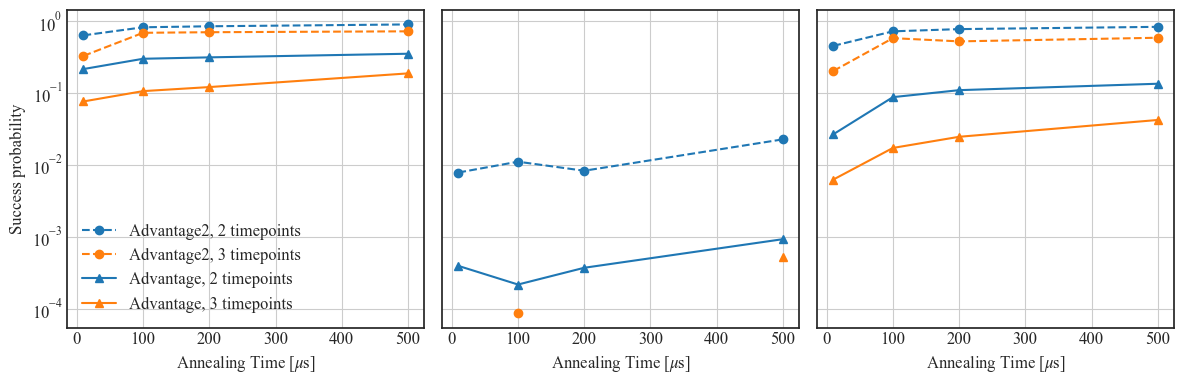

In [ ]:
import pandas as pd

annealing_times = [10,100,200,500]
timepoints_of_interest = [2, 3]
topologies = ['1.4', '6.4']
solver_names = {
    '1.4':'Advantage2',
    '6.4':'Advantage',
}
systems = [2,3,9]

# przygotowanie figure z dwoma subplotami
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
colors = {2: 'tab:blue', 3: 'tab:orange'}
linestyles = {'1.4': 'dashed', '6.4': 'solid'}
markers = {'1.4': 'o', '6.4': '^'}
titles = {2: rf'$\left| \Psi_{system} \right\rangle$', 9: '^'}


for ax, system in zip(axes, systems):
    data = {tp: {t: [] for t in timepoints_of_interest} for tp in topologies}

    for topology in topologies:
        for ta in annealing_times:
            df = helpers.get_dwave_success_rates(system, topology=topology, ta=ta, grouped=True)
            df = df[df['timepoints'].isin(timepoints_of_interest)]
            for tp in timepoints_of_interest:
                val = df[df['timepoints'] == tp]['success_prob'].values
                data[topology][tp].append(val[0] if len(val) > 0 else None)

    for topology in topologies:
        for tp in timepoints_of_interest:
            tas = [ta for i,ta in enumerate(annealing_times) if data[topology][tp][i] >0 ]
            data[topology][tp] = [p for p in data[topology][tp] if p >0]
            ax.plot(
                tas,
                data[topology][tp],
                label=f'{solver_names[topology]}, {tp} timepoints',
                color=colors[tp],
                linestyle=linestyles[topology],
                marker=markers[topology]
            )

    #ax.set_title(rf'$\widehat K_{system}$')
    ax.set_xlabel(r'Annealing Time [$\mu$s]')
    ax.set_yscale('log')
    ax.grid(True)

axes[0].set_ylabel('Success probability')
axes[0].legend(loc='lower left', fontsize=12)
plt.tight_layout()
plt.savefig(f'../plots/system_2_9_ta.pdf',bbox_inches='tight')
plt.show()


In [33]:
annealing_times = [10,100,200,500]
timepoints_of_interest = [2]
topologies = ['1.4', '6.4']
solver_names = {
    '1.4':'Advantage2',
    '6.4':'Advantage',
}
native_systems = [1,2,4,5,6,7]
not_native_systems = [3,8]

ratio_dfs = []


for systems in [native_systems, not_native_systems]:
    dfs =[]
    for system in systems:
        for topology in topologies:
            for ta in annealing_times:
                df = helpers.get_dwave_success_rates(system, topology=topology, ta=ta, grouped=True)
                df = df[df['timepoints'].isin(timepoints_of_interest)]
                df['system'] = system
                df['ta'] = ta
                dfs.append(df)

    combined_df = pd.concat(dfs)
    combined_df = combined_df[['topology','success_prob','ta']].groupby(by=['topology','ta']).mean()
    df_reset = combined_df.reset_index()

    df_14 = df_reset[df_reset['topology'] == '1.4'].set_index('ta')[['success_prob']]
    df_64 = df_reset[df_reset['topology'] == '6.4'].set_index('ta')[['success_prob']]
    ratio_dfs.append(df_14 / df_64)

In [34]:
ratio_df = ratio_dfs[0].copy()
ratio_df['p_ratio_non_native'] = ratio_dfs[1]['success_prob'].copy() 
ratio_df=ratio_df.rename({'success_prob':'p_ratio_native'},axis=1)
print(ratio_df.to_latex())

\begin{tabular}{lrr}
\toprule
 & p_ratio_native & p_ratio_non_native \\
ta &  &  \\
\midrule
10 & 5.240761 & 19.882828 \\
100 & 4.628113 & 51.031250 \\
200 & 4.045027 & 22.351648 \\
500 & 3.733719 & 24.429150 \\
\bottomrule
\end{tabular}



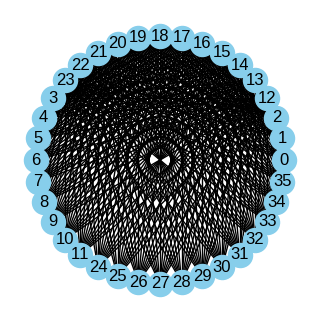

In [35]:
inst =instance.Instance(3)
inst.create_instance(precision=3,number_time_points=3)
G = dimod.to_networkx_graph(inst.qubo)
pos = nx.circular_layout(G)
fig = plt.figure(figsize=(3, 3))
fig.tight_layout()
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='black')
plt.savefig(f'../plots/system5_before_emb.pdf',bbox_inches='tight')

{1: [228, 50, 230, 229], 0: [222, 220, 221], 2: [216, 218, 217], 12: [56, 57, 59, 58], 13: [68, 71, 69, 70, 245], 14: [63, 60, 62, 61], 15: [92, 95, 94, 93], 16: [91, 88, 90, 89], 17: [84, 81, 238, 83, 82], 18: [24, 25, 27, 26], 19: [28, 31, 30, 29], 20: [20, 236, 23, 22, 21], 21: [32, 33, 34, 35], 22: [180, 181, 67, 66, 64, 65], 23: [212, 16, 19, 18, 17], 3: [75, 260, 262, 261], 4: [78, 210, 196, 197, 77], 5: [79, 264, 265, 266], 6: [43, 244, 242, 241], 7: [258, 256, 257], 8: [55, 54, 224, 226, 225], 9: [44, 184, 186, 185], 10: [168, 170, 169], 11: [36, 176, 178, 177], 24: [51, 254, 252, 253], 25: [86, 232, 233, 234], 26: [87, 268, 270, 269], 27: [162, 160, 161], 28: [166, 164, 165], 29: [52, 174, 172, 173], 30: [214, 208, 209, 213], 31: [42, 248, 249, 250, 46], 32: [45, 190, 189, 41, 188], 33: [200, 202, 201], 34: [204, 206, 205], 35: [194, 192, 37, 193]}


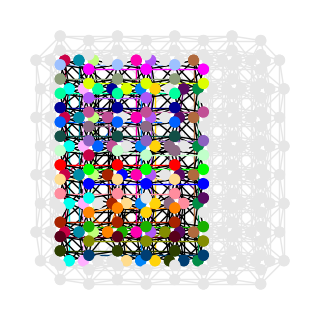

In [190]:
def visualize_embedding(bqm, target='pegasus', shape=None, embed=None):
    """
    Osadzenie i wizualizacja BQM na grafie Pegasus lub Zephyr.
    
    target : 'pegasus' lub 'zephyr'
    shape   :
      - Pegasus: int (np. 16)
      - Zephyr : tuple (m, n, t) (np. (4, 4, 4))
    """
    if target == 'pegasus':
        hw = dnx.pegasus_graph(shape)
    elif target == 'zephyr':
        hw = dnx.zephyr_graph(m=4,t=2)
    else:
        raise ValueError("target musi być 'pegasus' lub 'zephyr'.")

    # znajdowanie embeddingu, jeśli nie podano
    if embed is None:
        edgelist = list(hw.edges())
        embed = minorminer.find_embedding(bqm.quadratic, edgelist)
        if not embed:
            raise RuntimeError("Nie udało się znaleźć embeddingu.")
    print(embed)
    # rysowanie
    plt.figure(figsize=(3, 3))
    if target == 'pegasus':
        dnx.draw_pegasus_embedding(hw, embed, with_labels=False, node_size=50, crosses=True)
    elif target == 'zephyr':
        dnx.draw_zephyr_embedding(G=hw, emb=embed, with_labels=False, node_size=50)

    plt.axis('off')
    fig.tight_layout()
    plt.savefig(f'../plots/emb_{target}.pdf',bbox_inches='tight')
    plt.show()
bqm = inst.qubo
visualize_embedding(bqm, target='zephyr', shape=(4))
